In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [39]:
data_seed, params_seed = 42, 120

(42, 120)

In [3]:
import ReactiveMP.messageout

In [4]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [5]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [6]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2] # TODO: fix
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    neural_out = [NN(y_prev[i], u[i], params_f) for i in 1:n] #TODO: fix

    # create meta for AR
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + neural_out[t]
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        h_prev = h[t]
    end

    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [7]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(2), 0.1*diageye(2)), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [8]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [25]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 1, 1, 1
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [26]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[order_u:end];

In [27]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

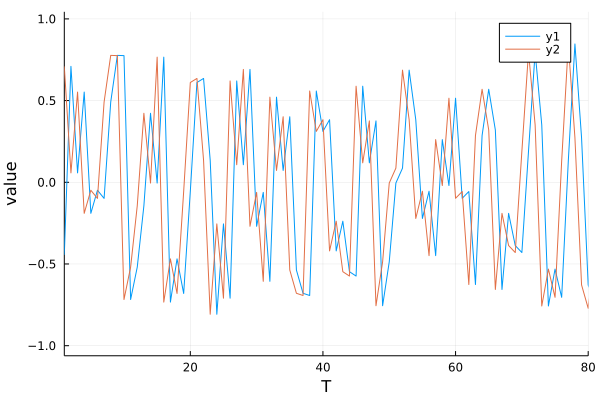

In [28]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value")

In [40]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
NN_param_len = 21
model_params = randn(flow_param_len+NN_param_len+2); #Flow, NN, Gamma

In [41]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=10);

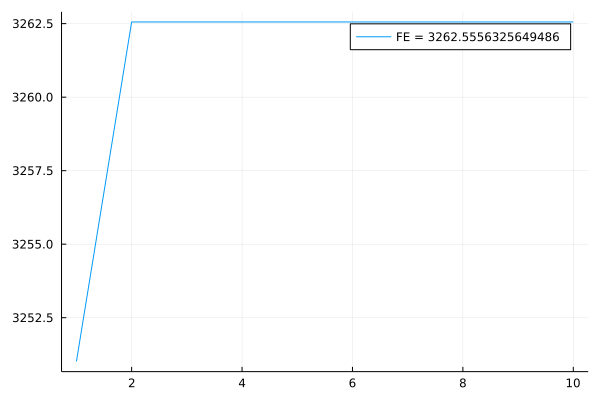

In [42]:
gr()
plot(fe, label="FE = $(fe[end])")

In [43]:
# Optimization function
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(zeros(2), 0.1*diageye(2)), 
                                                 vmp_its=1)
    return fe[end]
end;

In [44]:
FE(model_params)

3251.0134420685918

In [93]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("dump/dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [2.1425, 1.16799, 0.665874, -2.26747, 1.30221, -0.11084, 0.97…

In [46]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     3.251003e+03     2.140239e+03
 * time: 0.00014781951904296875
     1     3.133244e+03     4.627403e+03
 * time: 2.406329870223999
     2     2.422006e+03     3.992261e+02
 * time: 4.3669960498809814
     3     2.129092e+03     2.442491e+02
 * time: 6.371029853820801
     4     2.023310e+03     3.851986e+02
 * time: 8.40016794204712
     5     1.953331e+03     2.480705e+02
 * time: 10.418560981750488
     6     1.905068e+03     2.665376e+02
 * time: 12.333653926849365
     7     1.862904e+03     2.099209e+02
 * time: 16.05070686340332
     8     1.829613e+03     2.166157e+02
 * time: 17.932246923446655
     9     1.810964e+03     3.468378e+02
 * time: 20.57706904411316
    10     1.769681e+03     2.653364e+02
 * time: 22.285279035568237
    11     1.742333e+03     1.772927e+02
 * time: 23.989686965942383
    12     1.716681e+03     3.399850e+02
 * time: 26.665925979614258
    13     1.691307e+03     2.731912e+02
 * time: 28.66366791725

 * Status: success

 * Candidate solution
    Final objective value:     -2.985488e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.74e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   2072  (vs limit Inf)
    Iterations:    709
    f(x) calls:    2323
    ∇f(x) calls:   2323


In [47]:
inf_params = Optim.minimizer(res)


32-element Vector{Float64}:
  2.1425032796635595
  1.1679863543978828
  0.6658743936980027
 -2.2674731668162584
  1.3022101367584151
 -0.11084035261544452
  0.9798453932837867
 -1.3318910462603724
 -0.3643946922607826
 -0.29919855634963866
 -0.4570597071514212
  0.28356694855003045
  1.6406811319051784
  ⋮
 -0.6668378357253967
  0.6872329513688744
  1.6760362487267217
 -1.2058738649981522
 -0.7216279109841288
  0.4315153875773737
  0.708401028611139
 -0.15589829685656778
 -0.27521171272588973
 -0.24387486717285586
  8.644668801991875
  0.7843295461082177

In [48]:
using JLD
JLD.save("dump/dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [49]:
FE(inf_params)

-298.5488200734817

In [76]:
inf_params = Optim.minimizer(res)
fe_inf, h_inf, w_inf, y_out_inf, θ_inf = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);

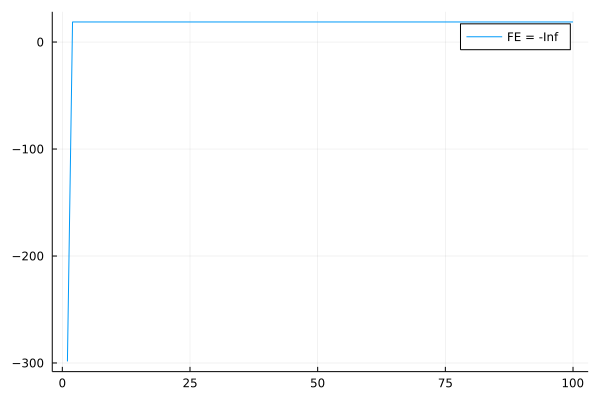

In [77]:
plot(fe_inf[1:end], label="FE = $(fe[end])")

In [52]:
from, to = 100, 300

(100, 300)

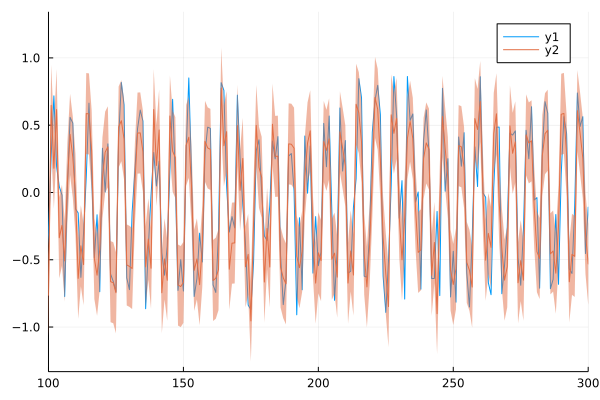

In [53]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(from, to))
plot!(my, ribbon=sqrt.(vy))

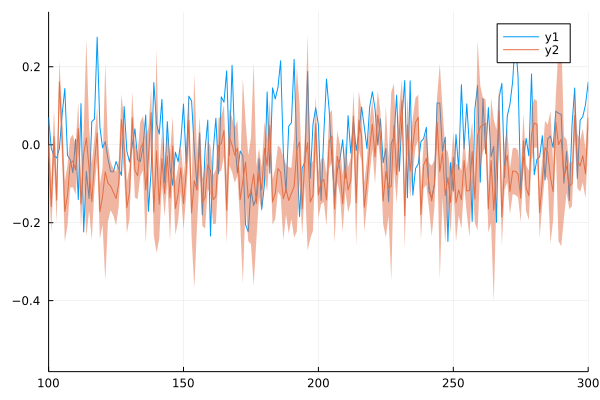

In [54]:
mh, vh = mean.(h), cov.(h)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [55]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [62]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    A = shift(dim) # transition matrix
    V = transition(w, dim)

    # initialize variables
    y_pred   = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    NN_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + NN_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [68]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, w, h_prior,
                                                                                                    observation_prev, control,
                                                                                                    options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [79]:
predictions = []
h_prev = (mean(h_inf[end]), precision(h_inf[end]))
ŵ = mean(w_inf)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    h_prev = (mean(h), precision(h))
end

In [80]:
w_pred = mean(w)

11.02173040004173

In [81]:
mx, vx = mean.(predictions), cov.(predictions)

([0.522763514776743, -0.3570993952052063, -0.36500519303924345, -0.3276832534092882, 0.7248329019788295, 0.5760039663676825, 0.5685800553927204, -0.35839062786069487, -0.3648910816817187, -0.36456701938568914  …  -0.3631519092577331, -0.3624639873700483, 0.5523666306756784, 0.5604148837931519, 0.6156405854441144, -0.2417456982025111, -0.36422436074412695, -0.3595825349490936, -0.14259752708944592, 0.7210747919081402], [2.8051211678070325, 2.911694772111655, 2.9116947721134063, 2.911694772113418, 2.9116947721133557, 2.911694772112777, 2.911694772112559, 2.9116947721125164, 2.911694772113407, 2.911694772113418  …  2.9116947721134143, 2.9116947721134188, 2.9116947721134143, 2.9116947721124227, 2.911694772112472, 2.911694772112748, 2.9116947721131985, 2.911694772113416, 2.9116947721134108, 2.911694772112951])

In [90]:
test_from, test_to = 150, 200

(150, 200)

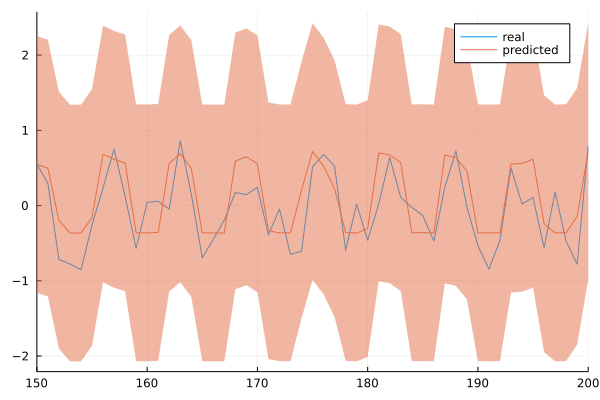

In [91]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")

In [84]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

200-element Vector{Float64}:
  7.145279582540799
  8.947288172744756
  8.71728934638433
  4.34053619664174
 -6.315909041983931
 -5.224340835451189
 -1.2109446107725699
  8.90034720904219
  8.741750093055009
  8.374008998093428
 -4.469381944298026
 -5.667367915074215
 -3.4634522703245256
  ⋮
  0.7952469883189105
  8.202692479565032
  8.857227464890512
  7.910080101360717
 -2.088545648140369
 -4.984770831928802
 -5.193659536951223
  6.814985487306902
  8.786686872710268
  8.926461299110608
  2.3335490113025235
 -6.599279754419854

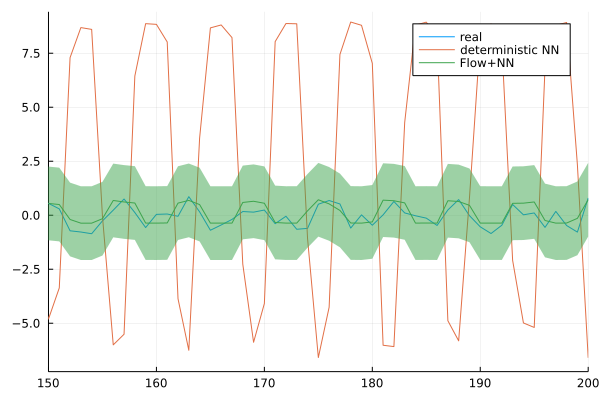

In [92]:
plot(Y_test, label="real")
plot!(n_output, label="deterministic NN")
plot!(mx, ribbon=sqrt.(vx), label="Flow+NN", xlims=(test_from, test_to))